In [19]:
import torch
import matplotlib.pyplot as plt

In [146]:
class PolynomialModel(torch.nn.Module):
    def __init__(self, degree=None):
        super().__init__()
        if degree is not None:
            self.coefficients = torch.nn.Parameter(torch.zeros(degree+1) )
        else:
            self.coefficients = torch.nn.Parameter(None)

    def forward(self, x):
        y = 0
        for n,c in enumerate(self.coefficients):
            y=y+c*x**n
        return y
    @property
    def degree(self):
        return len(self.coefficients)-1
        

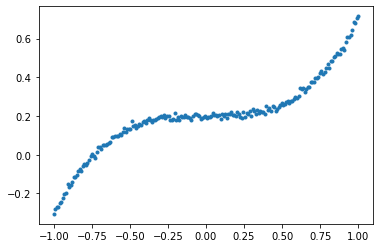

In [176]:
true = PolynomialModel()
true.coefficients = torch.nn.Parameter(torch.tensor((0.2, 0, -0.0, 0.5)))
x = torch.linspace(-1, 1, 200)
y = true(x)
y_data = (y + 0.01 * torch.randn_like(y)).detach()
plt.plot(x, y_data, ".")

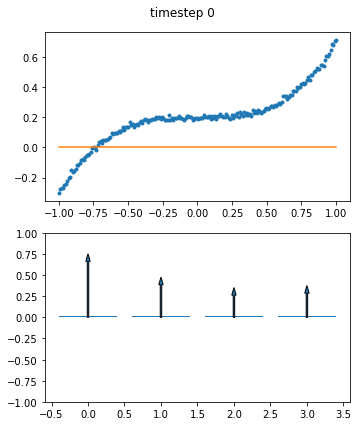

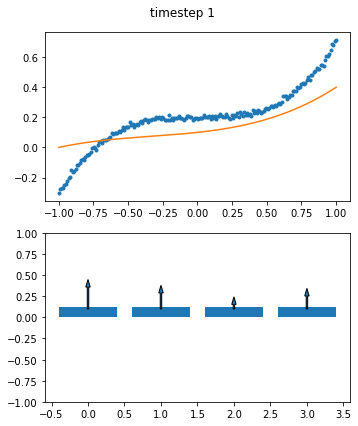

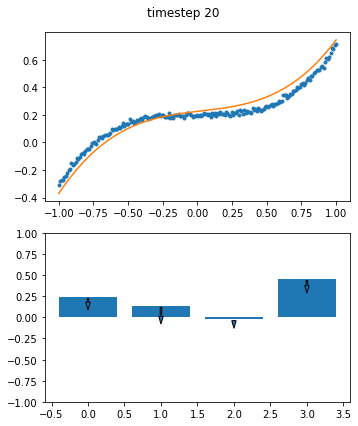

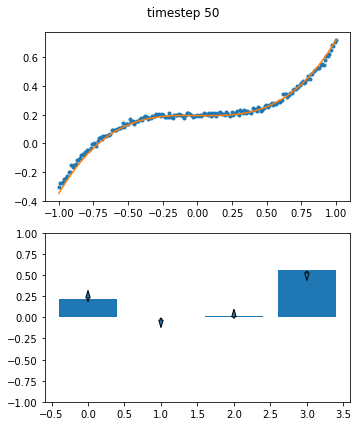

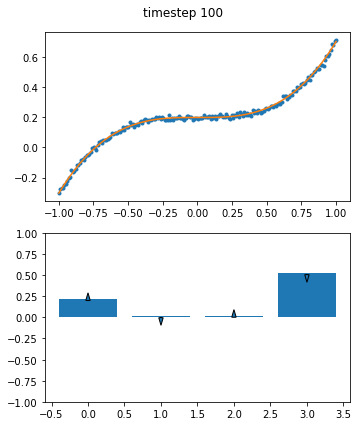

In [300]:
# This looks a bit more chaotic to get a nice animated gif out of it

from matplotlib.animation import FuncAnimation
import numpy as np

fit = PolynomialModel(true.degree)
optimizer = torch.optim.Adam(fit.parameters(), lr=0.1)


for step in range(101):
    # evaluate current function
    y_predict = fit(x)
    # calculate our similiarity meassure 
    loss = torch.sum((y_predict - y_data) ** 2)
    # let pytorch calculate the gradients
    loss.backward()
    
    # some plotting
    if step in [0,1,20,50,100]:
        f, (ax0, ax1) = plt.subplots(2, 1, figsize=(5, 6), tight_layout=True)
        ax0.plot(x, y_data, ".")
        ax0.plot(x, y_predict.detach(), "-")
        coeff = fit.coefficients.detach()
        grads = fit.coefficients.grad.detach()
        ax1.bar(range(len(coeff)), coeff+0.02)
        for i,(c,g) in enumerate(zip(coeff,grads)):
            w = -torch.tanh(0.01 * g)
            ax1.arrow(i, c, 0, w, width=0.02,)
        ax1.set_ylim(-1, 1)
        plt.suptitle(f"timestep {step}")
        plt.show()
    # end plotting
    
    # change the coefficient 
    optimizer.step()
    optimizer.zero_grad()
    

MovieWriter ffmpeg unavailable; using Pillow instead.
/home/zimmer08/.conda/envs/jlab/envs/ml/lib/python3.9/site-packages/torch/nn/functional.py:1956: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


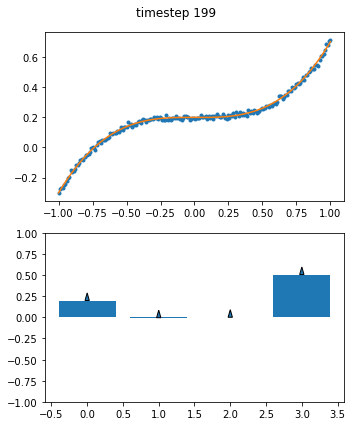

In [287]:
# This looks a bit more chaotic to get a nice animated gif out of it

from matplotlib.animation import FuncAnimation
import numpy as np

fit = PolynomialModel(true.degree)
optimizer = torch.optim.Adam(fit.parameters(), lr=0.1)
f, (ax0, ax1) = plt.subplots(2, 1, figsize=(5, 6), tight_layout=True)

ax0.plot(x, y_data, ".")
y_predict = fit(x)
line_fit = ax0.plot(x, y_predict.detach(), "-")[0]
coeff = fit.coefficients.detach()
bar = ax1.bar(range(len(coeff)), coeff)
arrows = [ax1.arrow(i, 0, 0, 0, width=0.02,) for i in range(len(coeff))]
ax1.set_ylim(-1, 1)


def update(i):
    label = f"timestep {i}"
    f.suptitle(label)
    y_predict = fit(x)
    loss = torch.sum((y_predict - y_data) ** 2)
    loss.backward()

    coeff = fit.coefficients.detach()
    grads = fit.coefficients.grad.detach()

    line_fit.set_data(x, y_predict.detach())
    for b, c in zip(bar, coeff):
        b.set_height(c)
    for a, g, c in zip(arrows, grads, coeff):
        w = -torch.nn.functional.tanh(0.01 * g)
        a.set_data(y=c, dy=w)
    optimizer.step()
    optimizer.zero_grad()
    return (line_fit, bar, *arrows)


anim = FuncAnimation(f, update, frames=np.arange(0, 200), interval=100)
anim.save("polynomial.gif", dpi=200)